Based on the HPO results, refit the model with different hyperparameters and evaluate the business metric

In [ ]:
seed = 1111


In [ ]:
# !pip install --upgrade xgboost
# !pip install catboost
# !pip install --upgrade numpy
# !pip install --upgrade pandas

# !pip install --upgrade scikit-learn
# !pip install --upgrade ipywidgets


import numpy as np  # This line should remain to import the correct version
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import lightgbm as lgb

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [ ]:
!pip install fairlearn
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    equal_opportunity_ratio,
    equal_opportunity_difference,
    selection_rate,
    true_positive_rate
)
from sklearn.metrics import accuracy_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 6.4 MB/s eta 0:00:00


In [ ]:
import pickle
with open(f"/content/drive/MyDrive/math6912/data/state_CA_cleaned_business_train_1111.pkl", "rb") as f:
    df = pickle.load(f)
with open(f"/content/drive/MyDrive/math6912/data/state_CA_cleaned_business_val_1111.pkl", "rb") as f:
    df_val = pickle.load(f)
with open(f"/content/drive/MyDrive/math6912/data/state_CA_cleaned_business_test_1111.pkl", "rb") as f:
    df_test = pickle.load(f)

In [ ]:
# selected_cols = ['derived_race', 'applicant_sex', 'applicant_age_above_62',
#                  'loan_type', 'loan_purpose', 'open-end_line_of_credit',
#                  'loan_amount', 'loan_to_value_ratio', 'loan_term',
#                  'property_value', 'total_units', 'income',
#                  'debt_to_income_ratio', 'tract_median_age_of_housing_units',
#                  'applicant_credit_score_type']

In [ ]:
# len(selected_cols)

In [ ]:
# df = df[selected_cols]
# df_val = df_val[selected_cols]
# df_test  = df_test[selected_cols]

In [ ]:
cols = ['derived_race', 'applicant_sex', 'applicant_age_above_62', 'loan_type',
       'loan_purpose', 'open-end_line_of_credit', 'loan_amount',
       'loan_to_value_ratio', 'loan_term', 'property_value', 'total_units',
       'income', 'debt_to_income_ratio', 'tract_median_age_of_housing_units',
       'applicant_credit_score_type']

In [ ]:
len(cols)

15

In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
with open(f"/content/drive/MyDrive/math6912/preprocessing/data_preprocessing_1111_11.pkl", 'rb') as f:
    save_dict = pickle.load(f)

In [ ]:
le = save_dict['le']
selected_cols = save_dict['cols']
categorical_cols = save_dict['categorical_cols']

In [ ]:
# df = df[selected_cols]
# df_val = df_val[selected_cols]
# df_test = df_test[selected_cols]

In [ ]:
le

{'derived_race': LabelEncoder(),
 'applicant_sex': LabelEncoder(),
 'applicant_age_above_62': LabelEncoder(),
 'loan_type': LabelEncoder(),
 'loan_purpose': LabelEncoder(),
 'open-end_line_of_credit': LabelEncoder(),
 'applicant_credit_score_type': LabelEncoder()}

In [ ]:

# prompt: get all the ordered categorical features

ordered_categorical_features = []
for col in df_test.select_dtypes(include=['category']).columns.tolist():
    if df_test[col].cat.ordered:
        ordered_categorical_features.append(col)
print(ordered_categorical_features)

# prompt: get the categorical columns excluded ordered

_categorical_features = [col for col in categorical_cols if col not in ordered_categorical_features]
_categorical_features

# prompt: labelencoder for categorical columns

print("Categorical")
for col in _categorical_features:
    print(col)
    df[col] = le[col].transform(df[col])
    df[col] = df[col].astype('category')
    df_val[col] = le[col].transform(df_val[col])
    df_val[col] = df_val[col].astype('category')
    df_test[col] = le[col].transform(df_test[col])
    df_test[col] = df_test[col].astype('category')
    # X_test[col] = le.fit_transform(X_test[col])
    # X_test[col] = X_test[col].astype('category')
print("="*50)
print("Ordinal")
for col in ordered_categorical_features:
    print(col)
    df[col] = df[col].cat.codes
    df_val[col] = df_val[col].cat.codes
    df_test[col] = df_test[col].cat.codes


# categorical_cols = df_test.select_dtypes(include=['category']).columns.tolist()
# print(categorical_cols)

['applicant_age', 'co-applicant_age', 'total_units', 'debt_to_income_ratio']
Categorical
derived_race
applicant_sex
applicant_age_above_62
loan_type
loan_purpose
open-end_line_of_credit
applicant_credit_score_type
Ordinal
applicant_age
co-applicant_age
total_units
debt_to_income_ratio


# Our method

In [ ]:
# prompt: stratefied sampling for X_train_b, y_train_b

from sklearn.model_selection import StratifiedShuffleSplit


# Now, X_train_b_sampled and y_train_b_sampled contain your stratified sample


In [ ]:
def eod(model, X, y, m_cols=None, thrsh=[0.5, 0.5]):
    tpr_w, _ = tpr_fn(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    tpr_b, _ = tpr_fn(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    return tpr_w - tpr_b, np.min([tpr_w, tpr_b])/np.max([tpr_w, tpr_b])


In [ ]:
def tpr_fn(model, X, y, m_cols=None, thrsh=0.5):
    if m_cols is None:
        _X = X
    else:
        _X = X[m_cols]
    y_thrsh = (model.predict(_X) > thrsh).astype(int)
    _y = y
    tp = (y_thrsh[_y==1] == 1)
    tpr = tp.sum()/(_y[_y == 1]==1).sum()
    return tpr, tp

In [ ]:
import numpy as np
import copy
from sklearn.utils import resample

def race_balanced(X, y, y_ratio=None, seed=seed):
    """Balances the dataset using SMOTE, considering racial groups and y_ratio.

    Args:
        X: The input features (data).
        y: The target variable (labels).
        y_ratio: Desired proportions of each race and class combination.
        seed: Controls the random number generation for SMOTE.

    Returns:
        X_resampled: Resampled features.
        y_resampled: Resampled target variable.
    """

    # Identify race columns
    X_resampled_list = []
    y_resampled_list = []
    smote_list = []
    if y_ratio is None:
        y_ratio = [0.25] * 4
    y_ratio = copy.deepcopy(y_ratio)

    n = len(X)

    # Single race column logic (apply SMOTE with modified sampling_strategy)
    for i in range(2):
        replace = True
        X_race = X[i]
        y_race = y[i]
        if len(X_race) == 0:
            continue
        # Calculate desired class proportions for the current race
        # print(y_ratio[2*i], y_ratio[2*i + 1])
        if type(y_ratio[2*i]) == int:
            n_samples_race = (y_ratio[2*i] + y_ratio[2*i + 1])
        elif type(y_ratio[2*i]) == float:
            n_samples_race = int(len(X) * (y_ratio[2*i] + y_ratio[2*i + 1])) # Total for this race
        else:
            y_ratio[2*i] = int((y_race == 0).sum())
            y_ratio[2*i + 1] = int((y_race == 1).sum())
            n_samples_race = (y_ratio[2*i] + y_ratio[2*i + 1])
            replace = False

        # print(race, y_ratio[2*i], y_ratio[2*i + 1])
        # Get the original number of samples for each class within this race
        class_counts = y_race.value_counts()

        # Create the sampling_strategy dictionary
        sampling_strategy = {}
        for class_label, desired_proportion in zip([0, 1], [y_ratio[2*i], y_ratio[2*i + 1]]):
            # Ensure that we oversample or keep the original number of samples
            desired_proportion = desired_proportion if type(desired_proportion) == int else int(n * desired_proportion)
            # print("After", desired_proportion, class_counts.get(class_label, 0), n)
            sampling_strategy[class_label] = desired_proportion


        # Apply SMOTE with the adjusted sampling_strategy for the current race
        # print(sampling_strategy, X_race.shape, y_race.shape)
        # if sampling_strategy[0] > 100000:
        #     raise
        # print(sampling_strategy)
        # if subsample_flag:
        #     smote = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=seed)
        # else:
        for class_label in [0, 1]:
            num_samples = sampling_strategy[class_label]
            X_resampled_race, y_resampled_race = resample(X_race[y_race == class_label],
                                                          y_race[y_race == class_label],
                                                          replace=replace,
                                                          n_samples=num_samples,
                                                          random_state=seed)
            X_resampled_list.append(X_resampled_race)
            y_resampled_list.append(y_resampled_race)

    X_resampled = pd.concat(X_resampled_list)
    y_resampled = pd.concat(y_resampled_list)
    idx = np.random.RandomState(seed=seed).permutation(X_resampled.shape[0])
    X_resampled = X_resampled.iloc[idx]
    y_resampled = y_resampled.iloc[idx]

    return X_resampled, y_resampled

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import lightgbm as lgb
import time
class CustomLGBClassifier:
    def __init__(self, params, n_estimators=10,
                 y_ratio1=[10000, 40000, 10000, 40000],
                 y_ratio2=[10000, 40000, 25000, 25000],
                 resample_chance=1.0, seed=seed, verbose=-1):
        self.model = None
        self.n_estimators = n_estimators
        self.seed = seed
        self.y_ratio1 = y_ratio1
        self.y_ratio2 = y_ratio2
        self.params = params
        self.resample_chance = resample_chance
        self.verbose = verbose


        # self.smote = SMOTE(sampling_strategy='auto', random_state=42)
        return

    def fit(self, X, y, cols=None, finetune=15):
        np.random.seed(self.seed)
        rand_idx = np.random.permutation(len(X))
        X = X
        y = y
        # print(self)
        _eod = 0

        # Assuming X_train_b and y_train_b are your data
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=self.seed)  # Adjust test_size as needed
        for train_index, val_index in split.split(X[0], y[0]):
            X_train_b_sampled, X_val_b_sampled = X[0].iloc[train_index], X[0].iloc[val_index]
            y_train_b_sampled, y_val_b_sampled = y[0].iloc[train_index], y[0].iloc[val_index]
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=self.seed+1)  # Adjust test_size as needed
        for train_index, val_index in split.split(X_train_w, y_train_w):
            X_train_w_sampled, X_val_w_sampled = X[1].iloc[train_index], X[1].iloc[val_index]
            y_train_w_sampled, y_val_w_sampled = y[1].iloc[train_index], y[1].iloc[val_index]
        X_train = pd.concat([X_train_b_sampled, X_train_w_sampled]).reset_index(drop=True)
        y_train = pd.concat([y_train_b_sampled, y_train_w_sampled]).reset_index(drop=True)
        rand_idx = np.random.RandomState(seed=self.seed).permutation(len(X_train))
        X_train = X_train.iloc[rand_idx]
        y_train = y_train.iloc[rand_idx]

        X_val = pd.concat([X_val_b_sampled, X_val_w_sampled]).reset_index(drop=True)
        y_val = pd.concat([y_val_b_sampled, y_val_w_sampled]).reset_index(drop=True)
        rand_idx = np.random.RandomState(seed=self.seed+1).permutation(len(X_val))
        X_val = X_val.iloc[rand_idx]
        y_val = y_val.iloc[rand_idx]

        for i in range(self.n_estimators):
            start = time.time()
            rand_resample  = np.random.rand()
            # if i < warm_up:
            if self.model is not None:
                _eod, _ =  eod(self,
                            [X_val_w_sampled, X_val_b_sampled],
                            [y_val_w_sampled, y_val_b_sampled],
                            m_cols=cols, thrsh=[0.5, 0.5])
            else:
                _eod = 0

            # if rand_resample < self.resample_chance:
            if _eod > 0.0 and rand_resample < self.resample_chance:
                # print(self.y_ratio1, self.y_ratio2)
                X_resampled, y_resampled = race_balanced([X_train_b_sampled, X_train_w_sampled],
                                                         [y_train_b_sampled, y_train_w_sampled],
                                                         y_ratio=self.y_ratio2, seed=self.seed)
            else:
                X_resampled, y_resampled = race_balanced([X_train_b_sampled, X_train_w_sampled],
                                                         [y_train_b_sampled, y_train_w_sampled],
                                                         y_ratio=self.y_ratio1, seed=self.seed)
            if cols is not None:
                X_resampled = X_resampled[cols]
            # Train LightGBM model
            train_data = lgb.Dataset(X_resampled, label=y_resampled)
            valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            self.model = lgb.train(
                self.params,
                train_data,
                num_boost_round=10,  # Build one tree at a time
                valid_sets=[valid_data],
                init_model=self.model,  # Continue training from previous model
                keep_training_booster=True  # Keep previous trees
            )
            if self.verbose > 0:
                print(f"Epoch {i} - EOD: ", _eod)

            # print(f"Epoch {i} ")
            self.seed += 1
        if self.verbose > 0:
            print("Final - EOD: ", eod(self,
                                [X[1], X[0]],
                                [y[1], y[0]],
                                m_cols=cols, thrsh=[0.5, 0.5]))
        return



    def predict(self, X, cols=None):
        if cols is not None:
            X = X[cols]
        y_pred = self.model.predict(X)
        return y_pred



In [ ]:
import numpy as np
index_w = np.where(save_dict['le']['derived_race'].classes_ == 'White')[0][0]

index_b = np.where(save_dict['le']['derived_race'].classes_ == 'Black or African American')[0][0]


In [ ]:
print(index_w, index_b)

1 0


In [ ]:
# Assuming 'action_taken' is your target column
y_train = df['action_taken']
X_train = df.drop('action_taken', axis=1)[cols]
X_train_b = X_train[X_train['derived_race'] == index_b]
X_train_w = X_train[X_train['derived_race'] == index_w]
y_train_b = y_train[X_train['derived_race'] == index_b]
y_train_w = y_train[X_train['derived_race'] == index_w]

y_val = df_val['action_taken']
X_val = df_val.drop('action_taken', axis=1)[cols]
X_val_b = X_val[X_val['derived_race'] == index_b]
X_val_w = X_val[X_val['derived_race'] == index_w]
y_val_b = y_val[X_val['derived_race'] == index_b]
y_val_w = y_val[X_val['derived_race'] == index_w]

y_test = df_test['action_taken']
X_test = df_test.drop('action_taken', axis=1)[cols]
X_test_b = X_test[X_test['derived_race'] == index_b]
X_test_w = X_test[X_test['derived_race'] == index_w]
y_test_b = y_test[X_test['derived_race'] == index_b]
y_test_w = y_test[X_test['derived_race'] == index_w]


In [ ]:
print("Train w: ", y_train_w.value_counts()/len(y_train_w))
print("Train b: ", y_train_b.value_counts()/len(y_train_b))
print("Val w: ", y_val_w.value_counts()/len(y_val_w))
print("Val b: ", y_val_b.value_counts()/len(y_val_b))
print("Test w: ", y_test_w.value_counts()/len(y_test_w))
print("Test b: ", y_test_b.value_counts()/len(y_test_b))

Train w:  action_taken
1    0.83709
0    0.16291
Name: count, dtype: float64
Train b:  action_taken
1    0.749837
0    0.250163
Name: count, dtype: float64
Val w:  action_taken
1    0.83709
0    0.16291
Name: count, dtype: float64
Val b:  action_taken
1    0.749837
0    0.250163
Name: count, dtype: float64
Test w:  action_taken
1    0.83709
0    0.16291
Name: count, dtype: float64
Test b:  action_taken
1    0.749837
0    0.250163
Name: count, dtype: float64


In [ ]:
# results_df1 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_performance_only_resampling_mean_1111_10.csv")
# results_df1 = results_df1[0.05/(np.abs(results_df1['EOD Val']) + 0.05) > 0.7]
# import json
# json_str = results_df1.sort_values(by='Accuracy Val', ascending=False).iloc[0, 1]
# json_str = json_str.replace("'", "\"")
# best_params = json.loads(json_str)

In [ ]:
# best_params

In [ ]:
# params = {
#     "objective": "binary",
#     "metric": "binary_error",  # Equivalent to (1 - accuracy)
#     "boosting_type": "gbdt",
#     "verbosity": -1,
#     "random_state": seed,
#     "learning_rate": best_params['learning_rate'],
#     "num_leaves": best_params['num_leaves'],
#     "max_depth": best_params['max_depth'],
#     # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     "subsample": best_params['subsample'],
#     "categorical_feature": categorical_cols,
#     # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
#     # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
#     # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
# }
# # Train LightGBM model
# n_estimators = best_params["n_estimators"]
# # Train LightGBM model
# approval1 = best_params["approval1"]
# approval2 = best_params["approval2"]
# resample_chance = best_params["resample_chance"]
# balanced_ratio1 = best_params["balanced_ratio1"]
# balanced_ratio2 = best_params["balanced_ratio2"]
# model = CustomLGBClassifier(params = params, n_estimators=n_estimators,
#                             y_ratio1=[X_train.shape[0] * (1-balanced_ratio1) * (1-approval1),
#                                       X_train.shape[0] * (1-balanced_ratio1) * approval1,
#                                       X_train.shape[0] * balanced_ratio1 * 0.2,
#                                       X_train.shape[0] * balanced_ratio1 * 0.8],
#                             # y_ratio2=[None, None, None, None],
#                             #  y_ratio1=[62859 * 0.25, 293540 * 0.25, 62859 * 0.25, 293540 * 0.25],
#                             #  y_ratio2=[62859 * 0.2, 293540 * 0.2, 62859 * 0.25, 293540 * 0.25],
#                             y_ratio2=[X_train.shape[0] * (1-balanced_ratio2) * 0.2,
#                                       X_train.shape[0] * (1-balanced_ratio2) * 0.8,
#                                       X_train.shape[0] * balanced_ratio2 * (1-approval2),
#                                       X_train.shape[0] * balanced_ratio2 * approval2],
#                             resample_chance=resample_chance,
#                             seed=seed,
#                             verbose=-1,
# )
# model.fit([X_train_b, X_train_w], [y_train_b, y_train_w], cols=None)

In [ ]:


# with open("/content/drive/MyDrive/math6912/model/fae_performance.pkl", 'rb') as f:
#     model = pickle.load(f)

with open("/content/drive/MyDrive/math6912/model/fae_fair.pkl", 'rb') as f:
    model = pickle.load(f)

# with open("/content/drive/MyDrive/math6912/model/fae_balanced.pkl", 'rb') as f:
#     model = pickle.load(f)

In [ ]:
y_proba_train = model.predict(X_train)
y_pred_train = y_proba_train > 0.5
y_proba_test = model.predict(X_test)
y_pred_test = y_proba_test > 0.5

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time


# 4. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_test))
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy}")
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy}")
# MetricFrame analysis by race
mf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=X_test['derived_race'],
)

print("\n Group Fairness Metrics by Race:")
print(mf.by_group)

# Group fairness differences
dp_diff_dt = demographic_parity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_diff_dt = equal_opportunity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_ratio_dt = equal_opportunity_ratio(y_test, y_pred_test, sensitive_features=X_test['derived_race'])

print(f"\n Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f" Equal Opportunity Difference: {eod_diff_dt:.4f}")
print(f" Equal Opportunity Ratio: {eod_ratio_dt:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.49      0.61     65767
           1       0.90      0.98      0.94    324774

    accuracy                           0.89    390541
   macro avg       0.85      0.73      0.77    390541
weighted avg       0.89      0.89      0.88    390541

Confusion Matrix:
[[ 32106  33661]
 [  7939 316835]]
ROC AUC Score: 0.8375401963049707
Train Accuracy: 0.9001922973516225
Test Accuracy: 0.8934810941744913

 Group Fairness Metrics by Race:
              accuracy  selection_rate  true_positive_rate
derived_race                                              
0             0.846004        0.866637            0.975197
1             0.896669        0.899532            0.975577

 Demographic Parity Difference: 0.0329
 Equal Opportunity Difference: 0.0004
 Equal Opportunity Ratio: 0.9996


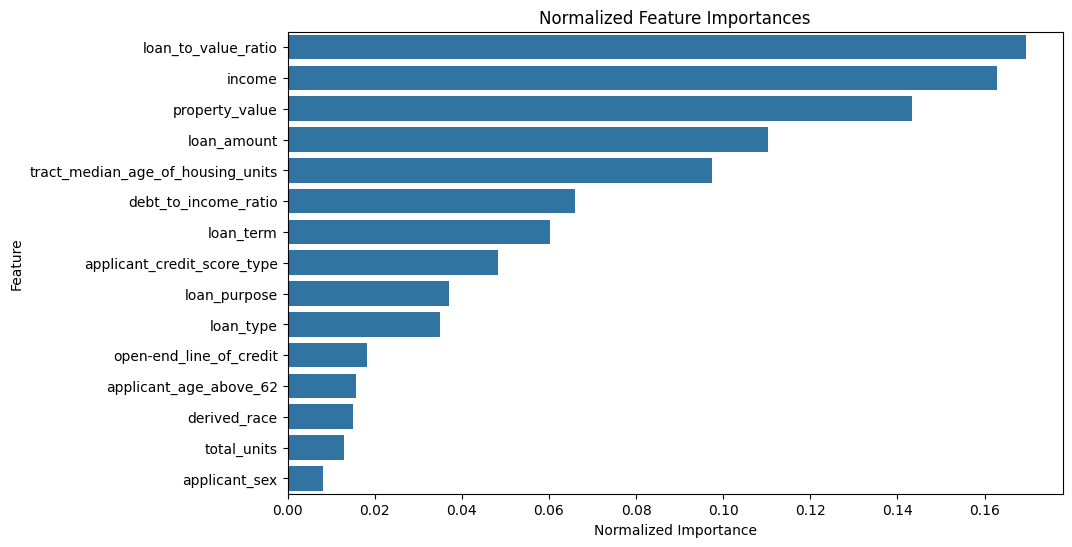

In [ ]:
# prompt: plot the normalized feature importances

import pandas as pd
import matplotlib.pyplot as plt
# Get feature importances
feature_importances = model.model.feature_importance()

# Normalize feature importances
feature_importances_normalized = feature_importances / feature_importances.sum()

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances_normalized})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the normalized feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Normalized Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()


# Performance Focused (Baseline LGBM)

In [ ]:
X_train = df.drop('action_taken', axis=1)
X_train = X_train[cols]
y_train = df['action_taken']
X_val = df_val.drop('action_taken', axis=1)
X_val = X_val[cols]
y_val = df_val['action_taken']
X_test = df_test.drop('action_taken', axis=1)
X_test = X_test[cols]
y_test = df_test['action_taken']

In [ ]:
categorical_cols = X_test.select_dtypes(include=['category']).columns.tolist()
categorical_cols

['derived_race',
 'applicant_sex',
 'applicant_age_above_62',
 'loan_type',
 'loan_purpose',
 'open-end_line_of_credit',
 'applicant_credit_score_type']

In [ ]:
# results_df1 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_performance_only_1111_10.csv")
# results_df1 = results_df1.sort_values(by='Accuracy Val', ascending=False)
# results_df1.head(10)
# import json
# json_str = results_df1.iloc[0, 1]
# json_str = json_str.replace("'", "\"")
# best_params = json.loads(json_str)

In [ ]:


# params = {
#     "device": "cpu",  # Enable GPU
#     "num_threads": -1,
#     "objective": "binary",
#     "metric": "binary_error",  # Equivalent to (1 - accuracy)
#     "boosting_type": "gbdt",
#     "verbosity": -1,
#     "random_state": seed,
#     'n_estimators': best_params['n_estimators'],
#     "learning_rate": best_params['learning_rate'],
#     "num_leaves": best_params['num_leaves'],
#     "max_depth": best_params['max_depth'],
#     # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     "subsample": best_params['subsample'],
#     "categorical_feature": categorical_cols,
#     # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
#     # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
#     # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
# }
# Train LightGBM model
# train_data = lgb.Dataset(X_train, label=y_train)
# valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# model = lgb.train(params, train_data, valid_sets=[valid_data])
# with open("/content/drive/MyDrive/math6912/model/performance.pkl", 'wb') as f:
#     pickle.dump(model, f)

with open("/content/drive/MyDrive/math6912/model/performance.pkl", 'rb') as f:
    model = pickle.load(f)

# print("=====================================")
# print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))

In [ ]:
y_proba_train = model.predict(X_train)
y_pred_train = y_proba_train > 0.5
y_proba_test = model.predict(X_test)
y_pred_test = y_proba_test > 0.5

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time


# 4. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_test))
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy}")
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy}")
# MetricFrame analysis by race
mf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=X_test['derived_race'],
)

print("\n Group Fairness Metrics by Race:")
print(mf.by_group)

# Group fairness differences
dp_diff_dt = demographic_parity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_diff_dt = equal_opportunity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_ratio_dt = equal_opportunity_ratio(y_test, y_pred_test, sensitive_features=X_test['derived_race'])

print(f"\n Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f" Equal Opportunity Difference: {eod_diff_dt:.4f}")
print(f" Equal Opportunity Ratio: {eod_ratio_dt:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.47      0.60     65767
           1       0.90      0.98      0.94    324774

    accuracy                           0.89    390541
   macro avg       0.87      0.73      0.77    390541
weighted avg       0.89      0.89      0.88    390541

Confusion Matrix:
[[ 31053  34714]
 [  6353 318421]]
ROC AUC Score: 0.8410808084815087
Train Accuracy: 0.906557826194945
Test Accuracy: 0.8948458676553807

 Group Fairness Metrics by Race:
              accuracy  selection_rate  true_positive_rate
derived_race                                              
0             0.848079        0.853980            0.968141
1             0.897986        0.907593            0.981178

 Demographic Parity Difference: 0.0536
 Equal Opportunity Difference: 0.0130
 Equal Opportunity Ratio: 0.9867


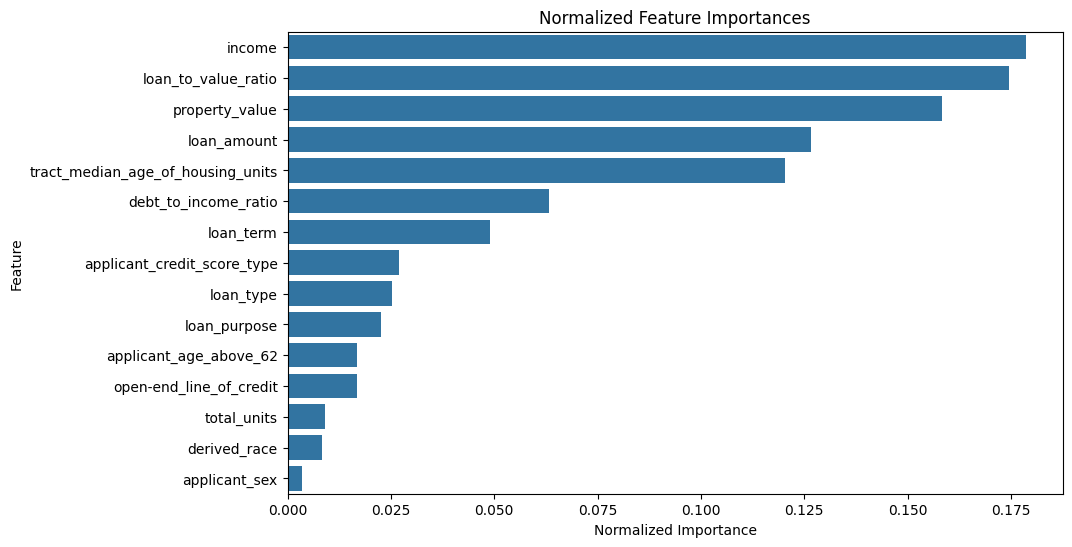

In [ ]:
# prompt: plot the normalized feature importances

import pandas as pd
import matplotlib.pyplot as plt
# Get feature importances
feature_importances = model.feature_importance()

# Normalize feature importances
feature_importances_normalized = feature_importances / feature_importances.sum()

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances_normalized})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the normalized feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Normalized Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()


# Fair Model (Baseline LGBM)

In [ ]:
X_train = df.drop('action_taken', axis=1)
X_train = X_train[cols]
y_train = df['action_taken']
X_val = df_val.drop('action_taken', axis=1)
X_val = X_val[cols]
y_val = df_val['action_taken']
X_test = df_test.drop('action_taken', axis=1)
X_test = X_test[cols]
y_test = df_test['action_taken']

In [ ]:
categorical_cols = X_test.select_dtypes(include=['category']).columns.tolist()
categorical_cols

['derived_race',
 'applicant_sex',
 'applicant_age_above_62',
 'loan_type',
 'loan_purpose',
 'open-end_line_of_credit',
 'applicant_credit_score_type']

In [ ]:
# results_df1 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_fixed_alpha_eod_1111_10.csv")
# results_df1 = results_df1[0.05/(np.abs(results_df1['EOD Val']) + 0.05) > 0.99]
# import json
# json_str = results_df1.sort_values(by='Accuracy Val', ascending=False).iloc[0, 1]
# json_str = json_str.replace("'", "\"")
# best_params = json.loads(json_str)

In [ ]:


# params = {
#     "device": "cpu",  # Enable GPU
#     "num_threads": -1,
#     "objective": "binary",
#     "metric": "binary_error",  # Equivalent to (1 - accuracy)
#     "boosting_type": "gbdt",
#     "verbosity": -1,
#     "random_state": seed,
#     'n_estimators': best_params['n_estimators'],
#     "learning_rate": best_params['learning_rate'],
#     "num_leaves": best_params['num_leaves'],
#     "max_depth": best_params['max_depth'],
#     # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     "subsample": best_params['subsample'],
#     "categorical_feature": categorical_cols,
#     # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
#     # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
#     # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
# }
# Train LightGBM model
# train_data = lgb.Dataset(X_train, label=y_train)
# valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# model = lgb.train(params, train_data, valid_sets=[valid_data])
# with open("/content/drive/MyDrive/math6912/model/fair.pkl", 'wb') as f:
#     pickle.dump(model, f)

with open("/content/drive/MyDrive/math6912/model/fair.pkl", 'rb') as f:
    model = pickle.load(f)

# print("=====================================")
# print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))

In [ ]:
y_proba_train = model.predict(X_train)
y_pred_train = y_proba_train > 0.5
y_proba_test = model.predict(X_test)
y_pred_test = y_proba_test > 0.5

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time


# 4. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_test))
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy}")
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy}")
# MetricFrame analysis by race
mf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=X_test['derived_race'],
)

print("\n Group Fairness Metrics by Race:")
print(mf.by_group)

# Group fairness differences
dp_diff_dt = demographic_parity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_diff_dt = equal_opportunity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_ratio_dt = equal_opportunity_ratio(y_test, y_pred_test, sensitive_features=X_test['derived_race'])

print(f"\n Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f" Equal Opportunity Difference: {eod_diff_dt:.4f}")
print(f" Equal Opportunity Ratio: {eod_ratio_dt:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.24      0.38     65767
           1       0.87      1.00      0.93    324774

    accuracy                           0.87    390541
   macro avg       0.90      0.62      0.65    390541
weighted avg       0.88      0.87      0.83    390541

Confusion Matrix:
[[ 15679  50088]
 [  1174 323600]]
ROC AUC Score: 0.8060283539013948
Train Accuracy: 0.8685618155328122
Test Accuracy: 0.8687410540762686

 Group Fairness Metrics by Race:
              accuracy  selection_rate  true_positive_rate
derived_race                                              
0             0.798633        0.945751            0.996364
1             0.873448        0.957592            0.996386

 Demographic Parity Difference: 0.0118
 Equal Opportunity Difference: 0.0000
 Equal Opportunity Ratio: 1.0000


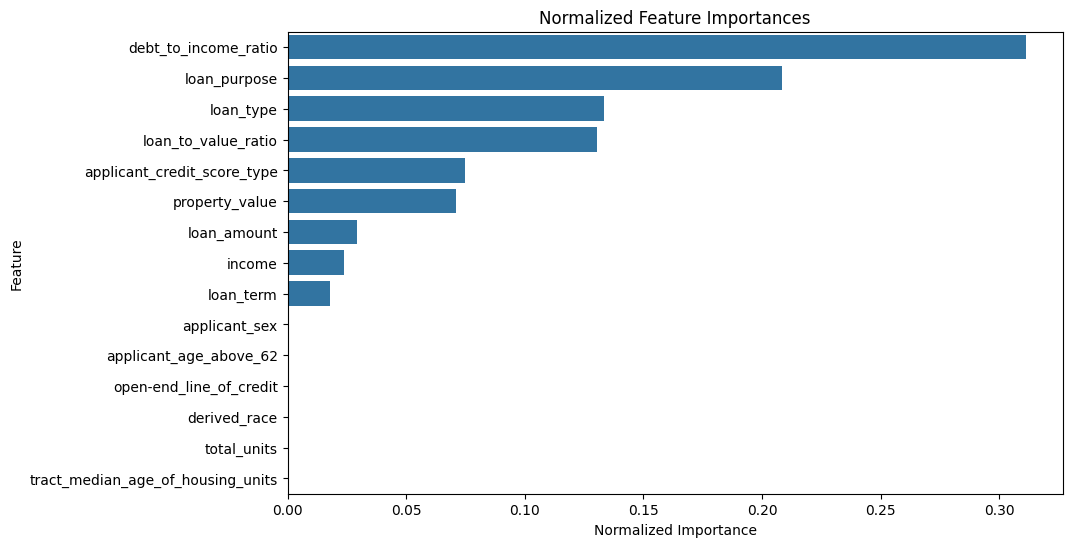

In [ ]:
# prompt: plot the normalized feature importances

import pandas as pd
import matplotlib.pyplot as plt
# Get feature importances
feature_importances = model.feature_importance()

# Normalize feature importances
feature_importances_normalized = feature_importances / feature_importances.sum()

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances_normalized})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the normalized feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Normalized Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()


# Performance Fairness Balanced Model (Baseline LGBM)

In [ ]:
X_train = df.drop('action_taken', axis=1)
X_train = X_train[cols]
y_train = df['action_taken']
X_val = df_val.drop('action_taken', axis=1)
X_val = X_val[cols]
y_val = df_val['action_taken']
X_test = df_test.drop('action_taken', axis=1)
X_test = X_test[cols]
y_test = df_test['action_taken']

In [ ]:
categorical_cols = X_test.select_dtypes(include=['category']).columns.tolist()
categorical_cols

['derived_race',
 'applicant_sex',
 'applicant_age_above_62',
 'loan_type',
 'loan_purpose',
 'open-end_line_of_credit',
 'applicant_credit_score_type']

In [ ]:
# results_df1 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_adjusted_alpha_eod_1111_10.csv")
# results_df1 = results_df1[0.05/(np.abs(results_df1['EOD Val']) + 0.05) > 0.9]
# import json
# json_str = results_df1.sort_values(by='Accuracy Val', ascending=False).iloc[0, 1]
# json_str = json_str.replace("'", "\"")
# best_params = json.loads(json_str)

In [ ]:


# params = {
#     "device": "cpu",  # Enable GPU
#     "num_threads": -1,
#     "objective": "binary",
#     "metric": "binary_error",  # Equivalent to (1 - accuracy)
#     "boosting_type": "gbdt",
#     "verbosity": -1,
#     "random_state": seed,
#     'n_estimators': best_params['n_estimators'],
#     "learning_rate": best_params['learning_rate'],
#     "num_leaves": best_params['num_leaves'],
#     "max_depth": best_params['max_depth'],
#     # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     "subsample": best_params['subsample'],
#     "categorical_feature": categorical_cols,
#     # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
#     # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
#     # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
# }
# Train LightGBM model
# train_data = lgb.Dataset(X_train, label=y_train)
# valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# model = lgb.train(params, train_data, valid_sets=[valid_data])
# with open("/content/drive/MyDrive/math6912/model/performance_fair.pkl", 'wb') as f:
#     pickle.dump(model, f)

with open("/content/drive/MyDrive/math6912/model/performance_fair.pkl", 'rb') as f:
    model = pickle.load(f)

# print("=====================================")
# print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("=====================================")
# print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
# print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
# print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))

In [ ]:
y_proba_train = model.predict(X_train)
y_pred_train = y_proba_train > 0.5
y_proba_test = model.predict(X_test)
y_pred_test = y_proba_test > 0.5

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time


# 4. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_test))
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy}")
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy}")
# MetricFrame analysis by race
mf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=X_test['derived_race'],
)

print("\n Group Fairness Metrics by Race:")
print(mf.by_group)

# Group fairness differences
dp_diff_dt = demographic_parity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_diff_dt = equal_opportunity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_ratio_dt = equal_opportunity_ratio(y_test, y_pred_test, sensitive_features=X_test['derived_race'])

print(f"\n Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f" Equal Opportunity Difference: {eod_diff_dt:.4f}")
print(f" Equal Opportunity Ratio: {eod_ratio_dt:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.43      0.57     65767
           1       0.89      0.98      0.94    324774

    accuracy                           0.89    390541
   macro avg       0.87      0.71      0.75    390541
weighted avg       0.89      0.89      0.88    390541

Confusion Matrix:
[[ 28152  37615]
 [  5033 319741]]
ROC AUC Score: 0.8325863969356715
Train Accuracy: 0.8922059399653302
Test Accuracy: 0.8907976371238872

 Group Fairness Metrics by Race:
              accuracy  selection_rate  true_positive_rate
derived_race                                              
0             0.840347        0.878968            0.979647
1             0.894185        0.917449            0.984795

 Demographic Parity Difference: 0.0385
 Equal Opportunity Difference: 0.0051
 Equal Opportunity Ratio: 0.9948


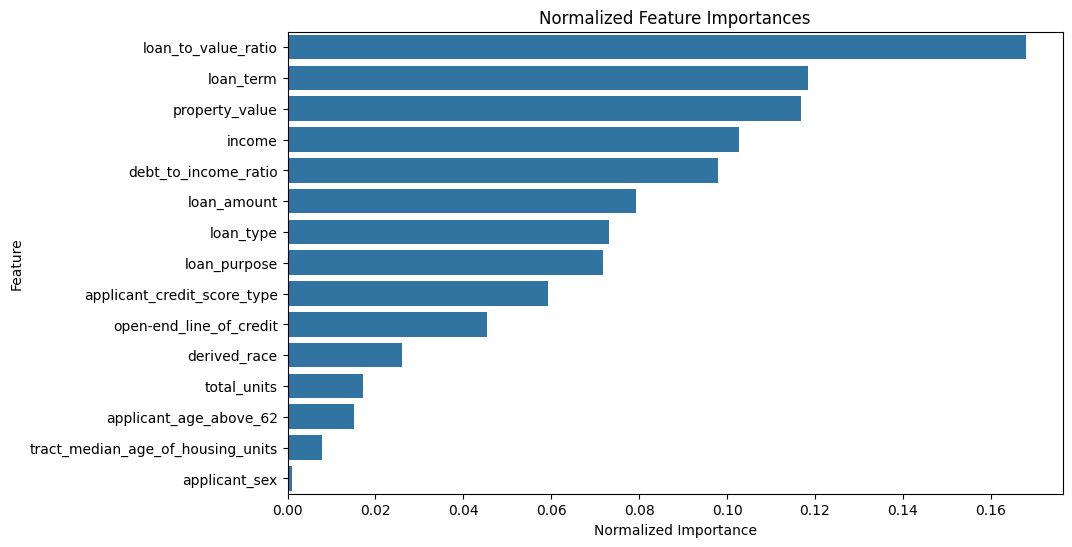

In [ ]:
# prompt: plot the normalized feature importances

import pandas as pd
import matplotlib.pyplot as plt
# Get feature importances
feature_importances = model.feature_importance()

# Normalize feature importances
feature_importances_normalized = feature_importances / feature_importances.sum()

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances_normalized})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the normalized feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Normalized Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()


# Baseline random forest

In [ ]:
X_train = df.drop('action_taken', axis=1)
X_train = X_train[cols]
y_train = df['action_taken']
X_val = df_val.drop('action_taken', axis=1)
X_val = X_val[cols]
y_val = df_val['action_taken']
X_test = df_test.drop('action_taken', axis=1)
X_test = X_test[cols]
y_test = df_test['action_taken']

In [ ]:
# categorical_cols = X_test.select_dtypes(include=['category']).columns.tolist()
# categorical_cols
# # prompt: get all the ordered categorical features

# ordered_categorical_features = []
# for col in categorical_cols:
#     if df_test[col].cat.ordered:
#         ordered_categorical_features.append(col)
# ordered_categorical_features

# # prompt: get the categorical columns excluded ordered

# _categorical_features = [col for col in categorical_cols if col not in ordered_categorical_features]
# _categorical_features

# # prompt: labelencoder for categorical columns
# from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# print("Categorical")
# for col in _categorical_features:
#     print(col)
#     le = LabelEncoder()
#     le.fit(pd.concat([X_train[col], X_val[col], X_test[col]]))
#     X_train[col] = le.transform(X_train[col])
#     X_train[col] = X_train[col].astype('category')
#     X_val[col] = le.transform(X_val[col])
#     X_val[col] = X_val[col].astype('category')
#     X_test[col] = le.transform(X_test[col])
#     X_test[col] = X_test[col].astype('category')
#     # X_test[col] = le.fit_transform(X_test[col])
#     # X_test[col] = X_test[col].astype('category')
# print("="*50)
# print("Ordinal")
# for col in ordered_categorical_features:
#     print(col)
#     X_train[col] = X_train[col].cat.codes
#     X_val[col] = X_val[col].cat.codes
#     X_test[col] = X_test[col].cat.codes


In [ ]:
# prompt: fit with random forest

from sklearn.ensemble import RandomForestClassifier
#
# Initialize the RandomForestClassifier
# model = RandomForestClassifier(random_state=seed, n_jobs=-1)

# Fit the classifier to the training data
# model.fit(X_train, y_train)
# with open("/content/drive/MyDrive/math6912/model/baseline.pkl", 'wb') as f:
#     pickle.dump(model, f)

with open("/content/drive/MyDrive/math6912/model/baseline.pkl", 'rb') as f:
    model = pickle.load(f)

In [ ]:
y_proba_train = model.predict(X_train)
y_pred_train = model.predict_proba(X_train)[:, 1] > 0.5
y_proba_test = model.predict(X_test)
y_pred_test = model.predict_proba(X_test)[:, 1] > 0.5

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time


# 4. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_test))
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy}")
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy}")
# MetricFrame analysis by race
mf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=X_test['derived_race'],
)

print("\n Group Fairness Metrics by Race:")
print(mf.by_group)

# Group fairness differences
dp_diff_dt = demographic_parity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_diff_dt = equal_opportunity_difference(y_test, y_pred_test, sensitive_features=X_test['derived_race'])
eod_ratio_dt = equal_opportunity_ratio(y_test, y_pred_test, sensitive_features=X_test['derived_race'])

print(f"\n Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f" Equal Opportunity Difference: {eod_diff_dt:.4f}")
print(f" Equal Opportunity Ratio: {eod_ratio_dt:.4f}")

# print(time.time()-start)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.46      0.59     65767
           1       0.90      0.98      0.94    324774

    accuracy                           0.89    390541
   macro avg       0.86      0.72      0.76    390541
weighted avg       0.89      0.89      0.88    390541

Confusion Matrix:
[[ 30294  35473]
 [  6638 318136]]
ROC AUC Score: 0.7200936608307398
Train Accuracy: 0.999815640355302
Test Accuracy: 0.8921726528072597

 Group Fairness Metrics by Race:
              accuracy  selection_rate  true_positive_rate
derived_race                                              
0             0.841283        0.861672            0.968738
1             0.895590        0.908372            0.980212

 Demographic Parity Difference: 0.0467
 Equal Opportunity Difference: 0.0115
 Equal Opportunity Ratio: 0.9883


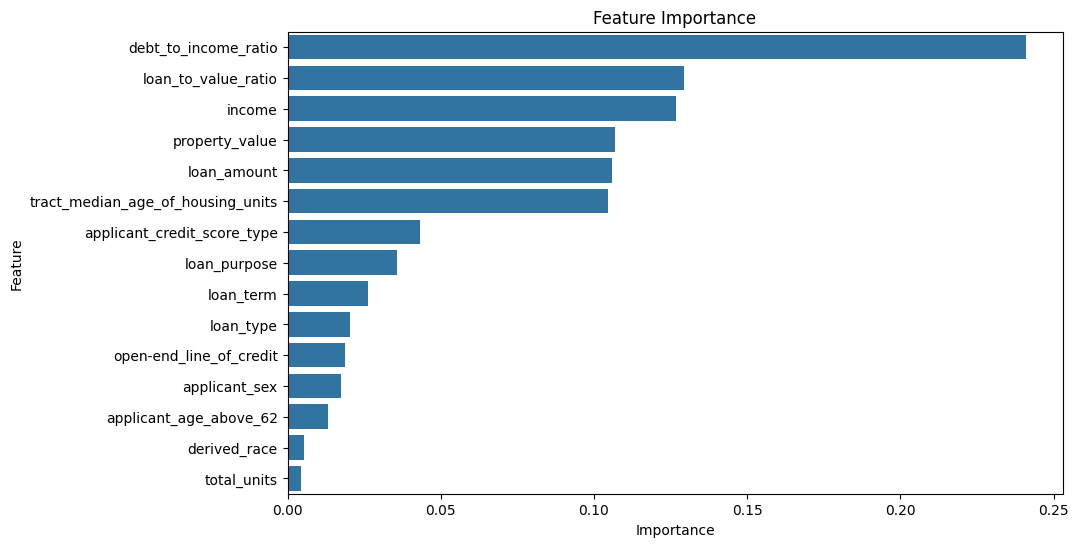

In [ ]:
# prompt: plot the feature importance

import pandas as pd
import matplotlib.pyplot as plt
importances = model.feature_importances_
feature_names = X_test.columns
# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# For experiment - Business metric
B = loan amount * interest rate * loan term + origination charges - default rate * (1-recovery rate) * loan amount

## Assumptions


1.   TP - good candidate - good default rate = 0.01
2.   NP - bad candidate - bad default rate = 0.04
3.   contant simple interest rate
4.   fill the missing value with median (with race or without race)



In [ ]:
_df_test = df_test.copy()

In [ ]:
_df_test['prediction'] = y_pred_test

In [ ]:
default_rate_good = 0.01
default_rate_bad = 0.04
recovery_rate = 0.
recovery_rate_good = 0.
recovery_rate_bad = 0.
cost_of_funds_rate = 0.0

In [ ]:
# prompt: fill median on some columns

import pandas as pd
import numpy as np


for _df in [_df_test]:
    for col in ['loan_amount', 'interest_rate', 'loan_term', 'origination_charges']:  # Add other numeric columns here as needed
        print(col, _df[col].isna().sum())
        median_val = _df[col].median()
        _df[col].fillna(median_val, inplace=True)
        print(col, _df[col].isna().sum())
        print("=================")
        print("=================")


loan_amount 0
loan_amount 0
interest_rate 67522
interest_rate 0
loan_term 5863
loan_term 0
origination_charges 115500
origination_charges 0


In [ ]:
_df_test[['loan_amount', 'interest_rate', 'loan_term', 'origination_charges', 'total_loan_costs']].describe()

,loan_amount,interest_rate,loan_term,origination_charges,total_loan_costs
count,3.905410e+05,390541.000000,390541.000000,390541.000000,271788.000000
mean,4.184263e+05,3.788429,339.601742,2546.561665,6068.836269
std,3.330331e+05,1.255820,54.864184,3002.374929,5044.813784
min,5.500000e+04,2.375000,180.000000,0.000000,495.000000
25%,2.250000e+05,2.990000,360.000000,1231.600000,2922.430000
50%,3.550000e+05,3.440000,360.000000,1620.000000,4509.055000
75%,5.150000e+05,4.125000,360.000000,2454.310000,7716.925000
max,2.495000e+06,9.990000,480.000000,21877.689500,31201.635850


In [ ]:
_df_test['business_metric_good'] = \
_df_test['loan_amount'] * (_df_test['interest_rate']/100/12 ) * _df_test['loan_term'] \
+ _df_test['origination_charges'] \
- default_rate_good * (1-recovery_rate_good) * _df_test['loan_amount']

In [ ]:
_df_test['business_metric_bad'] = \
_df_test['loan_amount'] * (_df_test['interest_rate']/100/12) * _df_test['loan_term']/12 \
+ _df_test['origination_charges'] \
- default_rate_bad * (1-recovery_rate_bad) * _df_test['loan_amount']

In [ ]:
_df_test[_df_test['action_taken'] == 1]['business_metric_good'].mean()

np.float64(469460.0419399085)

In [ ]:
_df_test['TP'] = 0
_df_test.loc[(_df_test['action_taken'] == 1) & (_df_test['prediction'] == 1), 'TP'] = 1
_df_test['NP'] = 0
_df_test.loc[(_df_test['action_taken'] == 0) & (_df_test['prediction'] == 1), 'NP'] = 1
print(_df_test['TP'].sum(), _df_test['NP'].sum())

319741 37615


In [ ]:
(_df_test[_df_test['TP'] == 1]['business_metric_good'].sum() + _df_test[_df_test['NP'] == 1]['business_metric_bad'].sum())/(_df_test['TP'] + _df_test['NP']).sum()

np.float64(422452.79246849054)

In [ ]:
# truth 348368.6236844447 324774 0
# baseline rf 340907.82891397655

# performance 341033.9119138739 318421 34714
# fair 334642.98399088415
# balanced 340141.4418644088

# fae 340548.5572485743
# fae fair 341079.0903938995
# fae balanced 341113.976619496 317585 34307

In [ ]:
# truth 469460.0419399085 324774 0

# performance 425674.61148179177 318421 34714
# fair 408241.657345022
# balanced 422452.79246849054

# fae
# fae fair 426710.09030735545 316835 33661
# fae balanced

# For experiment - Business metric with race median

In [ ]:
_df_test = df_test.copy()

In [ ]:
_df_test['prediction'] = y_pred_test

In [ ]:
default_rate_good = 0.005
default_rate_bad = 0.05
recovery_rate = 0.
recovery_rate_good = 0.
recovery_rate_bad = 0.
cost_of_funds_rate = 0.0

In [ ]:
_df_test['derived_race'].unique()

[1, 0]
Categories (2, int64): [0, 1]

In [ ]:
# prompt: fill median on some columns

import pandas as pd
import numpy as np


for _df in [_df_test]:
    for col in ['loan_amount', 'interest_rate', 'loan_term', 'origination_charges']:  # Add other numeric columns here as needed
        for race in _df['derived_race'].unique():
            median_val = _df[_df['derived_race'] == race][col].median()
            print(col, race, median_val)
            _df.loc[(_df['derived_race'] == race) & _df[col].isna(), col] = median_val
        # print(col, _df[col].isna().sum())
        print("=================")
        print("=================")



loan_amount 1 355000.0
loan_amount 0 345000.0
interest_rate 1 3.375
interest_rate 0 3.5
loan_term 1 360.0
loan_term 0 360.0
origination_charges 1 1595.0
origination_charges 0 1890.0


In [ ]:
_df_test[['loan_amount', 'interest_rate', 'loan_term', 'origination_charges', 'total_loan_costs']].describe()

,loan_amount,interest_rate,loan_term,origination_charges,total_loan_costs
count,3.905410e+05,390541.000000,390541.000000,390541.000000,271788.000000
mean,4.184263e+05,3.779217,339.601742,2545.923281,6068.836269
std,3.330331e+05,1.258626,54.864184,3002.878233,5044.813784
min,5.500000e+04,2.375000,180.000000,0.000000,495.000000
25%,2.250000e+05,2.990000,360.000000,1231.600000,2922.430000
50%,3.550000e+05,3.375000,360.000000,1595.000000,4509.055000
75%,5.150000e+05,4.125000,360.000000,2454.310000,7716.925000
max,2.495000e+06,9.990000,480.000000,21877.689500,31201.635850


In [ ]:
_df_test['business_metric_good'] = \
_df_test['loan_amount'] * (_df_test['interest_rate']/100 - cost_of_funds_rate) * _df_test['loan_term']/12 \
+ _df_test['origination_charges'] \
- default_rate_good * (1-recovery_rate_good) * _df_test['loan_amount']

In [ ]:
_df_test['business_metric_bad'] = \
_df_test['loan_amount'] * (_df_test['interest_rate']/100 - cost_of_funds_rate) * _df_test['loan_term']/12 \
+ _df_test['origination_charges'] \
- default_rate_bad * (1-recovery_rate_bad) * _df_test['loan_amount']

In [ ]:
_df_test[_df_test['action_taken'] == 1]['business_metric_good'].mean()

np.float64(471597.2403323547)

In [ ]:
_df_test['TP'] = 0
_df_test.loc[(_df_test['action_taken'] == 1) & (_df_test['prediction'] == 1), 'TP'] = 1
_df_test['NP'] = 0
_df_test.loc[(_df_test['action_taken'] == 0) & (_df_test['prediction'] == 1), 'NP'] = 1
print(_df_test['TP'].sum(), _df_test['NP'].sum())

319741 37615


In [ ]:
(_df_test[_df_test['TP'] == 1]['business_metric_good'].sum() + _df_test[_df_test['NP'] == 1]['business_metric_bad'].sum())/(_df_test['TP'] + _df_test['NP']).sum()

np.float64(460315.57462411956)

In [ ]:
# truth 348346.8456809972
# baseline rf 340276.8789046914

# performance 340409.0016273805
# fair 333876.7131955728
# balanced 339484.31219603657

# fae performance 339919.68879075925)
# fae balanced 340501.248625952
# fae fair 340478.4885403833